<a href="https://colab.research.google.com/github/kareemullah123456789/CNN-AI/blob/main/CNN_CaseStudy_TransferLearning_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Case Study: TF Flowers — CNN Architectures from Scratch
## Building, Comparing & Evaluating CNNs on a Small Image Dataset

---

### Table of Contents
1. Introduction & Dataset Overview
2. Environment Setup
3. Data Loading & Exploration
4. Data Preprocessing & Augmentation
5. Baseline CNN
6. Improved CNN with BatchNorm & Dropout
7. Deeper CNN with More Layers
8. CNN with Global Average Pooling
9. Model Comparison & Analysis
10. Confusion Matrix & Error Analysis
11. Conclusion

---

### Learning Objectives
- Load and preprocess a **real-world image dataset** using TensorFlow Datasets
- Build **multiple CNN architectures** from scratch and compare them
- Use **tf.data pipelines** for efficient data loading
- Apply **augmentation** to handle a small dataset
- Analyze model performance with **confusion matrices**


## 1. Introduction & Dataset Overview

### What is TF Flowers?
TF Flowers is a dataset of **3,670 flower photos** in **5 categories**.

| Property | Value |
|---|---|
| Total images | ~3,670 |
| Image sizes | Variable (resized to 96x96) |
| Classes | 5 |
| Source | Google TensorFlow Datasets |

### Classes
| Label | Flower |
|---|---|
| 0 | Dandelion |
| 1 | Daisy |
| 2 | Tulips |
| 3 | Sunflowers |
| 4 | Roses |

### Challenges
- **Small dataset**: Only ~3,670 images (much smaller than CIFAR-10's 60,000)
- **Variable image sizes**: Need to resize all images
- **Real photos**: Backgrounds, lighting, angles all vary
- Data augmentation is critical to avoid overfitting


## 2. Environment Setup


In [1]:
# Check TensorFlow version and GPU
import tensorflow as tf                            # Import TensorFlow
print(f'TensorFlow version: {tf.__version__}')     # Print version
print(f'GPU available: {tf.config.list_physical_devices("GPU")}')  # Check GPU


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Import all required libraries
import numpy as np                                 # Numerical operations
import matplotlib.pyplot as plt                    # Plotting
from tensorflow import keras                       # Keras API
from tensorflow.keras import layers, models, callbacks  # Layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix  # Metrics
import tensorflow_datasets as tfds                 # TF Datasets for loading data
import warnings                                    # Suppress warnings
warnings.filterwarnings('ignore')                  # Hide warnings

# Set random seeds
np.random.seed(42)                                 # Numpy seed
tf.random.set_seed(42)                             # TF seed

# Plot settings
plt.rcParams['figure.figsize'] = (12, 5)           # Default figure size
plt.rcParams['font.size'] = 11                     # Font size
print('All libraries imported.')                    # Confirm


All libraries imported.


## 3. Data Loading & Exploration


In [3]:
# Configuration
IMG_SIZE = 96          # Resize all images to 96x96 (small = less RAM)
BATCH_SIZE = 32        # Samples per training batch
NUM_CLASSES = 5        # 5 flower types
EPOCHS = 20            # Training epochs

# Class names for the 5 flower types
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
print(f'Image size: {IMG_SIZE}x{IMG_SIZE}')        # Print config
print(f'Classes: {class_names}')                    # Print classes


Image size: 96x96
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [4]:
# Load the TF Flowers dataset
# Split: 70% train, 15% validation, 15% test
(ds_train, ds_val, ds_test), info = tfds.load(
    'tf_flowers',                                  # Dataset name
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],  # Split ratios
    as_supervised=True,                            # Returns (image, label) pairs
    with_info=True                                 # Also return dataset info
)

# Count samples in each split
n_train = tf.data.experimental.cardinality(ds_train).numpy()  # Training count
n_val = tf.data.experimental.cardinality(ds_val).numpy()      # Validation count
n_test = tf.data.experimental.cardinality(ds_test).numpy()    # Test count

print(f'Training samples:   {n_train}')            # ~2569
print(f'Validation samples: {n_val}')              # ~550
print(f'Test samples:       {n_test}')             # ~551
print(f'Total:              {n_train + n_val + n_test}')  # ~3670


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.6SEZ8V_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Training samples:   2569
Validation samples: 551
Test samples:       550
Total:              3670


In [9]:
n_train.size

1

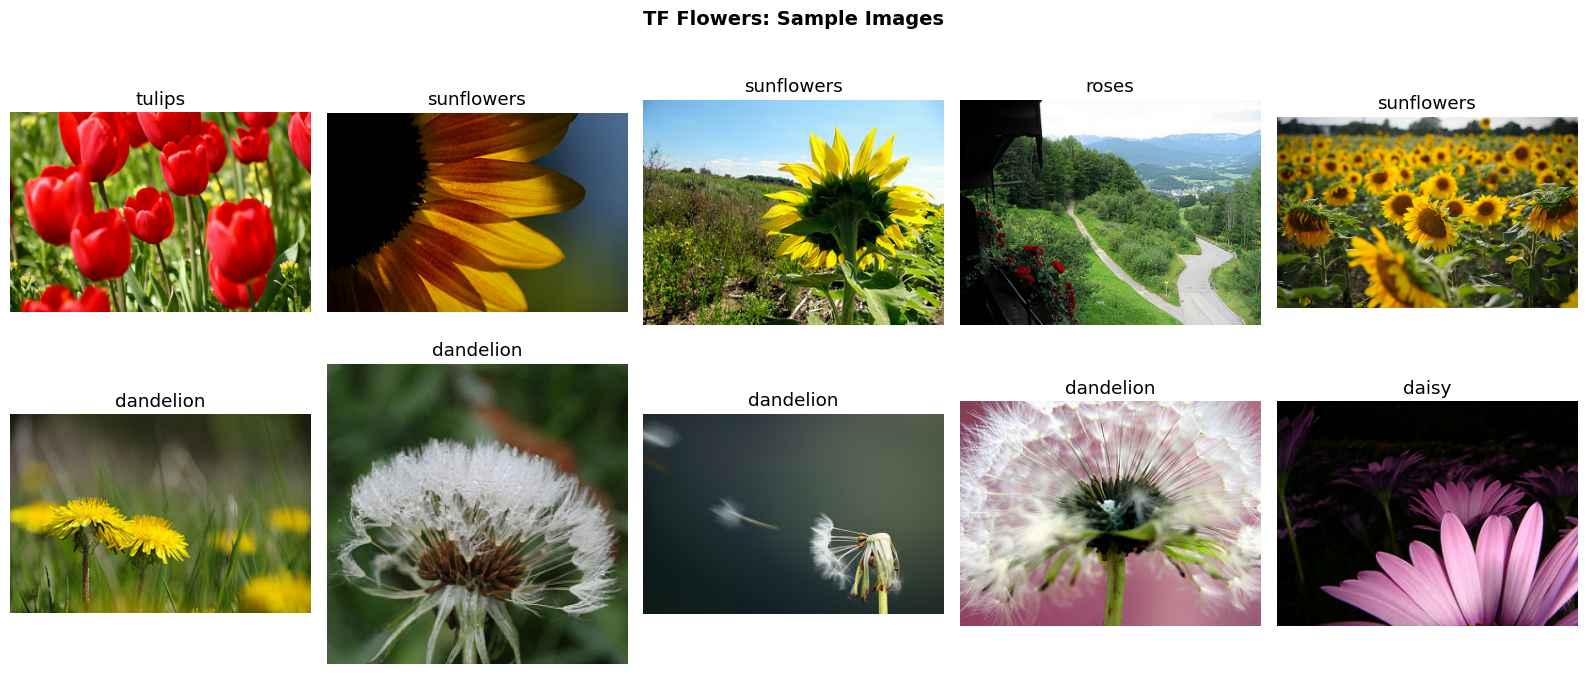

In [5]:
# Visualize sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(16, 7))   # 2 rows x 5 columns

# Take 10 samples from training set
for i, (image, label) in enumerate(ds_train.take(10)):  # Get 10 images
    ax = axes[i // 5, i % 5]                       # Select subplot position
    ax.imshow(image.numpy())                        # Show image (original size)
    ax.set_title(class_names[label.numpy()])        # Show class name
    ax.axis('off')                                  # Hide axes

plt.suptitle('TF Flowers: Sample Images', fontsize=14, fontweight='bold')
plt.tight_layout()                                  # Adjust layout
plt.show()                                          # Display


## 4. Data Preprocessing & Augmentation

We use **tf.data pipelines** for efficient data processing:
1. **Resize** all images to 96x96
2. **Normalize** pixel values to [0, 1]
3. **Augment** training images (flip, rotation, brightness)
4. **Batch and prefetch** for GPU efficiency


In [6]:
# Convert training images to numpy arrays (resize + normalize)
print('Loading training data...')
X_train_list, y_train_list = [], []                 # Empty lists
for image, label in ds_train:                        # Loop through training set
    img = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to 96x96
    img = tf.cast(img, tf.float32) / 255.0           # Normalize to [0, 1]
    X_train_list.append(img.numpy())                 # Save as numpy
    y_train_list.append(label.numpy())               # Save label
X_train = np.array(X_train_list)                     # Shape: (N, 96, 96, 3)
y_train = np.array(y_train_list)                     # Shape: (N,)
del X_train_list, y_train_list                       # Free memory

# Convert validation images to numpy arrays
print('Loading validation data...')
X_val_list, y_val_list = [], []                      # Empty lists
for image, label in ds_val:                           # Loop through val set
    img = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize
    img = tf.cast(img, tf.float32) / 255.0            # Normalize
    X_val_list.append(img.numpy())                    # Save
    y_val_list.append(label.numpy())                  # Save label
X_val = np.array(X_val_list)                          # Convert to array
y_val = np.array(y_val_list)                          # Convert labels
del X_val_list, y_val_list                            # Free memory

# Convert test images to numpy arrays
print('Loading test data...')
X_test_list, y_test_list = [], []                     # Empty lists
for image, label in ds_test:                           # Loop through test set
    img = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize
    img = tf.cast(img, tf.float32) / 255.0             # Normalize
    X_test_list.append(img.numpy())                    # Save
    y_test_list.append(label.numpy())                  # Save label
X_test_np = np.array(X_test_list)                      # Test images array
y_test_np = np.array(y_test_list)                      # Test labels array
del X_test_list, y_test_list                           # Free memory

# Set up data augmentation (no custom functions needed)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    horizontal_flip=True,                              # Random horizontal flip
    brightness_range=[0.8, 1.2],                       # Random brightness +/- 20%
    rotation_range=10                                  # Slight rotation
)
datagen.fit(X_train)                                   # Fit on training data

print(f'Training:   {X_train.shape}')                  # Print shapes
print(f'Validation: {X_val.shape}')
print(f'Test:       {X_test_np.shape}')
print('Data ready with augmentation.')

Loading training data...
Loading validation data...
Loading test data...
Training:   (2569, 96, 96, 3)
Validation: (551, 96, 96, 3)
Test:       (550, 96, 96, 3)
Data ready with augmentation.


## 5. Baseline CNN

A simple CNN with 3 conv blocks. No BatchNorm, no Dropout.
This gives us a reference accuracy to improve upon.


In [10]:
# Build baseline CNN - simple 3-block architecture
baseline = models.Sequential([                       # Sequential model
    # --- Conv Block 1 ---
    layers.Conv2D(32, (3, 3),                        # 32 filters, 3x3 kernel
                  activation='relu',                 # ReLU activation
                  padding='same',                    # Preserve spatial size
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # 96x96x3 RGB
    layers.MaxPooling2D((2, 2)),                     # 96x96 -> 48x48

    # --- Conv Block 2 ---
    layers.Conv2D(64, (3, 3),                        # 64 filters
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D((2, 2)),                     # 48x48 -> 24x24

    # --- Conv Block 3 ---
    layers.Conv2D(128, (3, 3),                       # 128 filters
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D((2, 2)),                     # 24x24 -> 12x12

    # --- Classifier ---
    layers.Flatten(),                                # Flatten: 12x12x128
    layers.Dense(128, activation='relu'),            # Dense: 128 units
    layers.Dense(NUM_CLASSES, activation='softmax')  # Output: 5 classes
])

# Compile the model
baseline.compile(
    optimizer='adam',                                # Adam optimizer
    loss='sparse_categorical_crossentropy',          # For integer labels
    metrics=['accuracy']                             # Track accuracy
)

# Show model architecture
baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453,317 (9.36 MB)

 Trainable params: 2,453,317 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
EPOCHS=5

In [13]:
# Define callbacks (used for all models)
my_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',                    # Watch val accuracy
        patience=5,                                # Stop after 5 epochs no improve
        restore_best_weights=True,                 # Keep best weights
        verbose=1                                  # Print when stopping
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',                        # Watch val loss
        factor=0.5,                                # Halve LR
        patience=3,                                # Wait 3 epochs
        min_lr=1e-6,                               # Minimum LR
        verbose=1                                  # Print LR changes
    )
]

# Train baseline with augmented data
print('Training Baseline CNN...')
h_baseline = baseline.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),  # Augmented training data
    epochs=EPOCHS,                                 # Max epochs
    validation_data=(X_val, y_val),                # Validation data (no augmentation)
    callbacks=my_callbacks,                        # Apply callbacks
    verbose=1                                      # Show progress
)

# Evaluate on test set
acc_baseline = baseline.evaluate(X_test_np, y_test_np, verbose=0)[1]  # Test accuracy
print(f'\nBaseline Test Accuracy: {acc_baseline:.4f}')

Training Baseline CNN...
Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.2502 - loss: 1.6023 - val_accuracy: 0.2323 - val_loss: 1.5950 - learning_rate: 0.0010
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.2518 - loss: 1.6013 - val_accuracy: 0.1506 - val_loss: 1.6071 - learning_rate: 0.0010
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.2552 - loss: 1.5978 - val_accuracy: 0.2414 - val_loss: 1.6491 - learning_rate: 0.0010
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.2358 - loss: 1.6020 - val_accuracy: 0.2849 - val_loss: 1.5847 - learning_rate: 0.0010
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.2284 - loss: 1.5977 - val_accuracy: 0.3049 - val_loss: 1.5911 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.

Baseline Test Accuracy: 0.2527


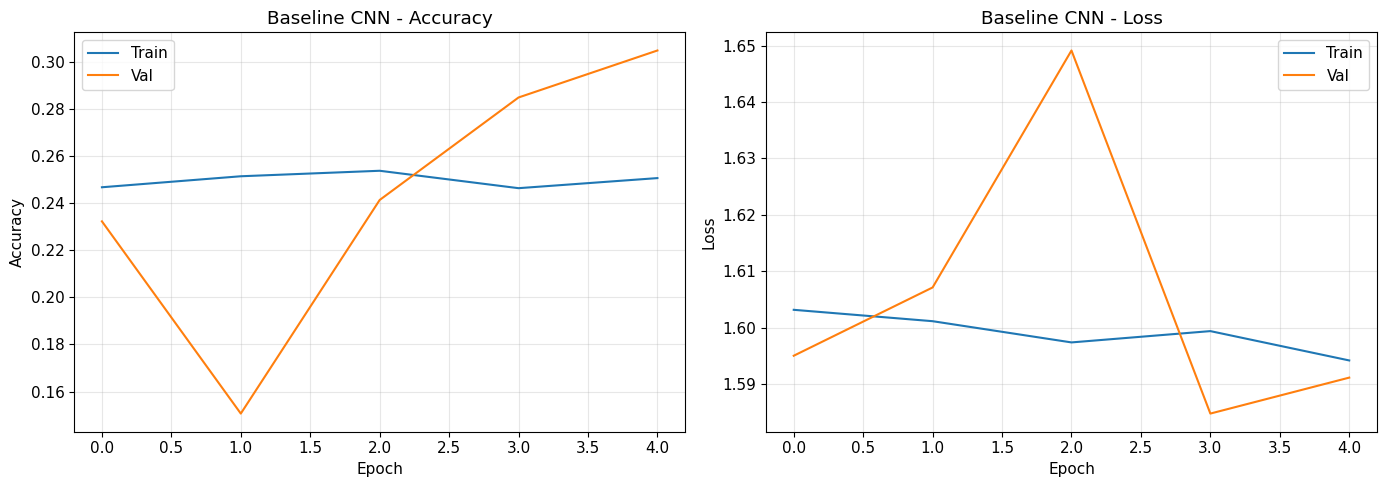

In [14]:
# Plot baseline training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(h_baseline.history['accuracy'], label='Train')
ax1.plot(h_baseline.history['val_accuracy'], label='Val')
ax1.set_title('Baseline CNN - Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(h_baseline.history['loss'], label='Train')
ax2.plot(h_baseline.history['val_loss'], label='Val')
ax2.set_title('Baseline CNN - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Improved CNN with BatchNorm & Dropout

Adding **BatchNormalization** and **Dropout** to reduce overfitting:
- BatchNorm stabilizes and speeds up training
- Dropout randomly disables neurons to prevent memorization


In [15]:
# Build improved CNN with BatchNorm and Dropout
improved = models.Sequential([
    # --- Conv Block 1 ---
    layers.Conv2D(32, (3, 3), activation='relu',
                  padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu',
                  padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 2 ---
    layers.Conv2D(64, (3, 3), activation='relu',
                  padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu',
                  padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 3 ---
    layers.Conv2D(128, (3, 3), activation='relu',
                  padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Classifier ---
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
improved.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train improved model
print('Training Improved CNN...')
h_improved = improved.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=my_callbacks, verbose=1
)

acc_improved = improved.evaluate(X_test_np, y_test_np, verbose=0)[1]
print(f'\nImproved CNN Test Accuracy: {acc_improved:.4f}')

Training Improved CNN...
Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.1913 - loss: 5.0484 - val_accuracy: 0.1561 - val_loss: 8.7813 - learning_rate: 0.0010
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.2165 - loss: 2.8887 - val_accuracy: 0.2396 - val_loss: 17.8417 - learning_rate: 0.0010
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.2400 - loss: 3.2447 - val_accuracy: 0.2559 - val_loss: 9.0633 - learning_rate: 0.0010
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.2372 - loss: 2.0827 - val_accuracy: 0.1452 - val_loss: 5.3947 - learning_rate: 0.0010
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.2296 - loss: 1.7692 - val_accuracy: 0.1906 - val_loss: 1.7330 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.

Improved CNN Test Accuracy: 0.2473


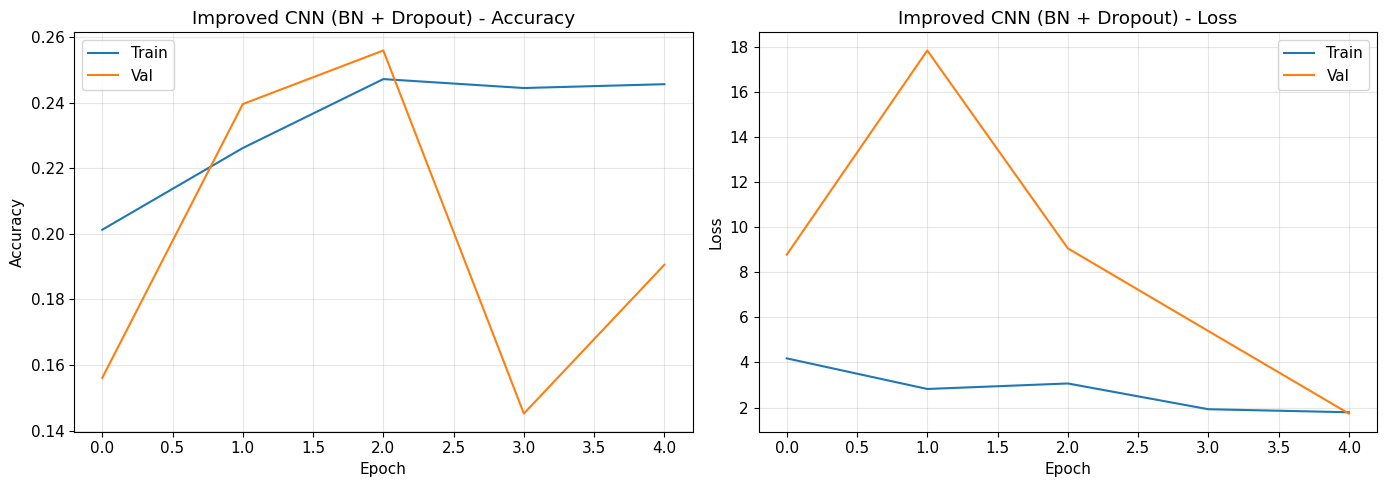

In [16]:
# Plot improved model training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(h_improved.history['accuracy'], label='Train')
ax1.plot(h_improved.history['val_accuracy'], label='Val')
ax1.set_title('Improved CNN (BN + Dropout) - Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(h_improved.history['loss'], label='Train')
ax2.plot(h_improved.history['val_loss'], label='Val')
ax2.set_title('Improved CNN (BN + Dropout) - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Deeper CNN with More Layers

A **deeper network** with 4 conv blocks can learn more complex patterns.
More layers = more hierarchical feature extraction.


In [17]:
# Build deeper CNN with 4 conv blocks
deeper = models.Sequential([
    # --- Conv Block 1 ---
    layers.Conv2D(32, (3, 3), activation='relu',
                  padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 2 ---
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 3 ---
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 4 ---
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Classifier ---
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
deeper.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Train deeper model
print('Training Deeper CNN...')
h_deeper = deeper.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=my_callbacks, verbose=1
)

acc_deeper = deeper.evaluate(X_test_np, y_test_np, verbose=0)[1]
print(f'\nDeeper CNN Test Accuracy: {acc_deeper:.4f}')

Training Deeper CNN...
Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.2003 - loss: 6.1273 - val_accuracy: 0.2486 - val_loss: 1.6347 - learning_rate: 0.0010
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.2263 - loss: 2.1765 - val_accuracy: 0.2305 - val_loss: 1.6333 - learning_rate: 0.0010
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.2462 - loss: 2.2766 - val_accuracy: 0.1488 - val_loss: 1.7272 - learning_rate: 0.0010
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.2615 - loss: 1.8278 - val_accuracy: 0.2305 - val_loss: 1.6053 - learning_rate: 0.0010
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.2395 - loss: 1.6846 - val_accuracy: 0.1670 - val_loss: 1.6446 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.

Deeper CNN Test Accuracy: 0.2400


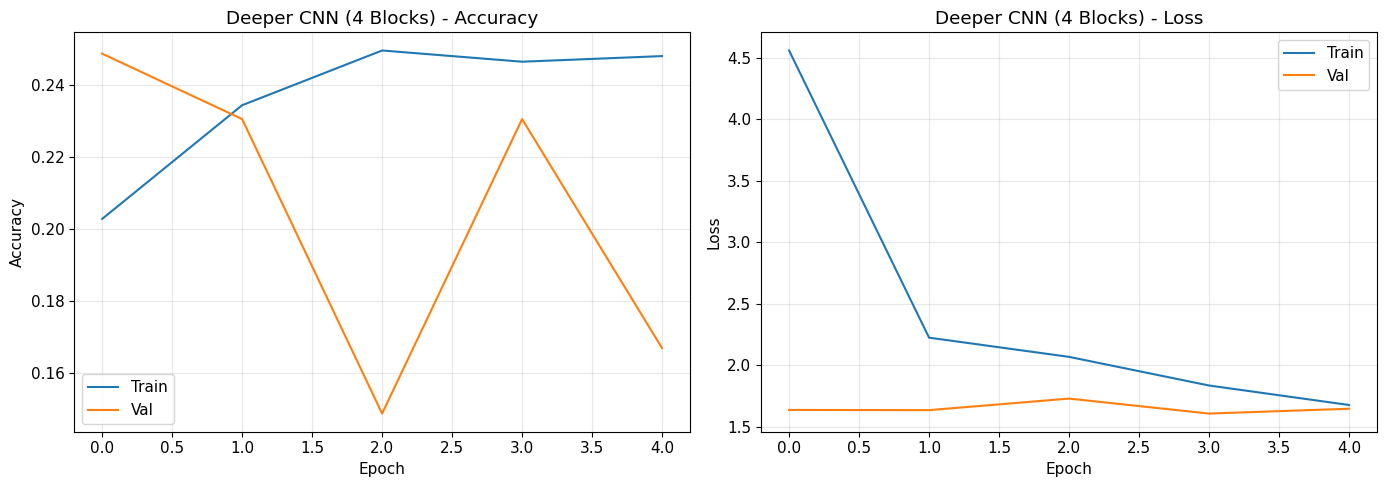

In [18]:
# Plot deeper model training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(h_deeper.history['accuracy'], label='Train')
ax1.plot(h_deeper.history['val_accuracy'], label='Val')
ax1.set_title('Deeper CNN (4 Blocks) - Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(h_deeper.history['loss'], label='Train')
ax2.plot(h_deeper.history['val_loss'], label='Val')
ax2.set_title('Deeper CNN (4 Blocks) - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. CNN with Global Average Pooling

**Global Average Pooling (GAP)** replaces the Flatten + Dense layer:
- Instead of flattening all feature maps into a huge vector,
  GAP takes the **average of each feature map** to produce one number per channel
- This **dramatically reduces parameters** and helps prevent overfitting

| Approach | Parameters | Overfitting Risk |
|---|---|---|
| Flatten + Dense | Very high | High |
| Global Average Pooling | Very low | Low |


In [19]:
# Build CNN with Global Average Pooling
gap_model = models.Sequential([
    # --- Conv Block 1 ---
    layers.Conv2D(32, (3, 3), activation='relu',
                  padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 2 ---
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Conv Block 3 ---
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Global Average Pooling (replaces Flatten + Dense) ---
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
gap_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train GAP model
print('Training GAP CNN...')
h_gap = gap_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=my_callbacks, verbose=1
)

acc_gap = gap_model.evaluate(X_test_np, y_test_np, verbose=0)[1]
print(f'\nGAP CNN Test Accuracy: {acc_gap:.4f}')

# Compare parameter counts
print(f'\nParameter counts:')
print(f'  Deeper CNN (Flatten): {deeper.count_params():>10,}')
print(f'  GAP CNN:              {gap_model.count_params():>10,}')
print(f'  Difference:           {deeper.count_params() - gap_model.count_params():>10,} fewer')

Training GAP CNN...
Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.2089 - loss: 1.7068 - val_accuracy: 0.1361 - val_loss: 1.8899 - learning_rate: 0.0010
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.2392 - loss: 1.6906 - val_accuracy: 0.2668 - val_loss: 2.1481 - learning_rate: 0.0010
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.2473 - loss: 1.6653 - val_accuracy: 0.2486 - val_loss: 2.9737 - learning_rate: 0.0010
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2428 - loss: 1.6693
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.2428 - loss: 1.6694 - val_accuracy: 0.2432 - val_loss: 3.7603 - learning_rate: 0.0010
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.2485 - loss: 1.6449 - val_accuracy: 0.3285 - val_loss: 5.3878 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 5.

GAP CNN Test

In [ ]:
# Plot GAP model training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(h_gap.history['accuracy'], label='Train')
ax1.plot(h_gap.history['val_accuracy'], label='Val')
ax1.set_title('GAP CNN - Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(h_gap.history['loss'], label='Train')
ax2.plot(h_gap.history['val_loss'], label='Val')
ax2.set_title('GAP CNN - Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Model Comparison & Analysis


In [ ]:
# Collect all results
results = {
    'Baseline CNN': acc_baseline,                   # Simple CNN
    'Improved (BN+Drop)': acc_improved,             # With BatchNorm + Dropout
    'Deeper (4 blocks)': acc_deeper,                # More layers
    'GAP CNN': acc_gap                              # Global Average Pooling
}

# Print results table
print(f'{"Model":<25} {"Test Accuracy":>15}')
print('=' * 42)
best_name = max(results, key=results.get)           # Find best model name
for name, acc in results.items():
    marker = ' <-- best' if name == best_name else ''  # Mark best
    print(f'  {name:<23} {acc:>13.4f}{marker}')    # Print each

# Bar chart comparison
plt.figure(figsize=(10, 5))                         # Figure size
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']  # Colors
bars = plt.bar(results.keys(), results.values(),
               color=colors, edgecolor='black')     # Create bars

for bar, acc in zip(bars, results.values()):        # Add labels
    plt.text(bar.get_x() + bar.get_width()/2,
             acc + 0.005, f'{acc:.4f}',
             ha='center', fontsize=11)

plt.ylabel('Test Accuracy')                         # Y label
plt.title('TF Flowers: CNN Architecture Comparison', fontsize=14, fontweight='bold')
plt.ylim(min(results.values()) - 0.05,
         max(results.values()) + 0.05)              # Y range
plt.xticks(rotation=15)                             # Rotate labels
plt.tight_layout()                                  # Adjust
plt.show()                                          # Display


## 10. Confusion Matrix & Error Analysis

The confusion matrix shows which classes the model confuses with each other.


In [ ]:
# Use the best-performing model for detailed analysis
# (We'll use the GAP model - adjust if another performed better)
best_model = gap_model                              # Best model

# Get predictions on test set
y_pred_probs = best_model.predict(X_test_np, verbose=0)  # Predicted probabilities
y_pred = y_pred_probs.argmax(axis=1)                # Convert to class indices

# Print classification report
print('Classification Report:')
print(classification_report(y_test_np, y_pred,
                            target_names=class_names,
                            digits=3))              # Show 3 decimal places


In [ ]:
# Plot confusion matrix
import seaborn as sns                               # For heatmap

cm = confusion_matrix(y_test_np, y_pred)            # Compute confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize rows

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Two plots

# Left: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Integer format
            xticklabels=class_names,
            yticklabels=class_names, ax=ax1)        # Labels
ax1.set_xlabel('Predicted')                         # X label
ax1.set_ylabel('True')                              # Y label
ax1.set_title('Confusion Matrix (Counts)')          # Title

# Right: Normalized (percentages)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',  # Float format
            xticklabels=class_names,
            yticklabels=class_names, ax=ax2)        # Labels
ax2.set_xlabel('Predicted')                         # X label
ax2.set_ylabel('True')                              # Y label
ax2.set_title('Confusion Matrix (Normalized)')      # Title

plt.tight_layout()                                  # Adjust
plt.show()                                          # Display


In [ ]:
# Show some misclassified images
wrong_idx = np.where(y_pred != y_test_np)[0]       # Find wrong predictions
n_show = min(10, len(wrong_idx))                    # Show up to 10 errors

fig, axes = plt.subplots(2, 5, figsize=(16, 7))    # 2 rows x 5 cols
for i, ax in enumerate(axes.flat[:n_show]):         # Loop
    idx = wrong_idx[i]                              # Get error index
    ax.imshow(X_test_np[idx])                       # Show image
    true_label = class_names[y_test_np[idx]]        # True class
    pred_label = class_names[y_pred[idx]]           # Predicted class
    ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                 fontsize=9, color='red')           # Red title for errors
    ax.axis('off')                                  # Hide axes

plt.suptitle('Misclassified Images', fontsize=14, fontweight='bold')
plt.tight_layout()                                  # Adjust
plt.show()                                          # Display


## 11. Conclusion

### Key Takeaways

**Small Dataset Challenges:**
- With only ~3,670 images, overfitting is a major concern
- Data augmentation is essential for small datasets
- Dropout and BatchNorm help regularize the model

**Architecture Insights:**
- A simple baseline CNN tends to overfit quickly
- Adding BatchNorm + Dropout significantly improves generalization
- Deeper networks can learn more complex features (but risk overfitting)
- Global Average Pooling reduces parameters dramatically

**Practical Guidelines:**
1. Start simple, then add complexity step by step
2. Always use a validation set to detect overfitting
3. Use data augmentation when your dataset is small
4. BatchNorm + Dropout is a strong baseline regularization combo
5. Global Average Pooling is a good alternative to Flatten + Dense

### Model Summary
| Model | Key Features | Parameters |
|---|---|---|
| Baseline | 3 conv + Flatten | High |
| Improved | + BN + Dropout | Medium |
| Deeper | 4 conv blocks | Higher |
| GAP | GlobalAveragePooling | Lowest |
